Описание данных
wellName Название скважины

datasetName Название набора данных

MD Измеренная глубина

BK Боковой каротаж (сопротивление)

Facies Фация (свойство)

GR Гамма-каротаж

LIT Литология

NKTB Нейтронный каротаж

SP Метод потенциалов собственной поляризации

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и плотных породах на большом интервале

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и коллекторах на большом интервале

Нужно определять фации в коллеторах (LIT = 4)

1 – глина

2 – алевролит

5- плотная порода

6 - уголь

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и плотных породах на большом интервале

Здесь тоже важно нормализацию проводить поскважинно и с учетом значений в глинах и коллекторах на большом интервале, но не выше 2000 м (MD>2000)

Самые основные конечно – GR и SP, их форму геологи учитывают для определения условий осадконакопления, можно будет попробовать оценить форму кривых, а не значения параметра) Единственный нюанс – пока в таблице всего 19 скважин, но фации в них выделены наиболее уверенно. Ну и судя по всему, информация с MD < 2000 не принципиальна

SP (каротаж естественной поляризации)
GR (гамма каротаж)
DT (акустический каротаж)
Density (плотностной каротаж)

In [1]:
# Загружаем необходимые библиотеки
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
import lasio
from os import listdir
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from IPython.display import display, clear_output
from sklearn.model_selection import StratifiedKFold
import talib
%matplotlib inline

In [37]:


def get_for_learn_clean_df(statistic_df):
    feature = statistic_df.copy()
    del feature['datasetName']
    #feature = feature[feature["Facies"] >= -999]
    feature = feature[feature["MD"] * 10 % 2 < 0.001]
    feature = feature[feature["MD"] > 1850]
    return feature

def get_for_learn_clean_df_spk400(statistic_df):
    feature = statistic_df.copy()
    del feature['datasetName']
    #feature = feature[feature["Facies"] >= -999]
    feature = feature[feature["MD"] * 10 % 2 > 0.001]
    feature = feature[feature["MD"] > 1850]
    feature['wellName'] = 'spk400_shift'
    return feature

def get_well_dfs(all_well_df):
    wall_names_ = all_well_df['wellName'].unique()
    print(wall_names_)
    wells = []
    for name in wall_names_:
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells

def get_for_learn_clean_df_spk427R(for_ml):
    def get_merge_df(one, two):
        one_copy =  one.copy()
        tho_copy = two.copy()
        new_df = pd.merge(one_copy, tho_copy,  how='inner', left_on=['wellName','MD'], right_on = ['wellName','MD'])
        return new_df

    for_ml_clone = for_ml.copy()
    for_ml_clone = for_ml_clone[for_ml_clone['wellName'] == 'spk427R']
    del for_ml_clone['BK']
    del for_ml_clone['SP']
    del for_ml_clone['NKTB']
    del for_ml_clone['LIT']
    del for_ml_clone['GR']
    del for_ml_clone['LAYER']

    spk427R = pd.read_csv('spk427R_TrainLogs.csv', sep=';')
    well = get_merge_df(for_ml_clone, spk427R)
    display(well.describe())
    del well['AGR']
    del well['ASP']
    del well['datasetName']
    return well

def get_well_dfs(all_well_df):
    wall_names_ = all_well_df['wellName'].unique()
    print(wall_names_)
    wells = []
    for name in wall_names_:
        well = all_well_df[all_well_df['wellName'] == name]
        wells.append(well)
    return wells

for_ml = get_for_learn_clean_df(pd.read_csv('DATATRAIN18+LAYER.csv', sep=';'))
spk427R = get_for_learn_clean_df_spk427R(for_ml)
spk400 = get_for_learn_clean_df_spk400(pd.read_csv('DATATRAIN18+LAYER.csv', sep=';'))
for_ml = for_ml[for_ml['wellName'] != 'spk427R']
for_ml = pd.concat([for_ml, spk400, spk427R])
display(for_ml.describe())
display(for_ml)
wells_samples_df = get_well_dfs(for_ml)

MD       Facies         AGR         ASP          BK  \
count   310.000000   310.000000  310.000000  310.000000  310.000000   
mean   2586.900000 -2415.990323    0.443719    0.091886    9.137045   
std      17.926703  4290.816865    0.260089    0.094558    7.720558   
min    2556.000000 -9999.000000    0.000000    0.000000    5.345500   
25%    2571.450000     0.000000    0.214541    0.011352    7.181000   
50%    2586.900000     5.000000    0.417163    0.052764    7.973250   
75%    2602.350000     5.000000    0.643623    0.178180    8.979625   
max    2617.800000     8.000000    1.000000    0.317823  129.264500   

               GR         LIT        NKTB          SP  
count  310.000000  310.000000  310.000000  310.000000  
mean    10.891935    2.051613    3.933336  113.830968  
std      3.222438    1.422398    0.650787    4.948310  
min      5.300000    1.000000    3.033252  103.900000  
25%      9.000000    1.000000    3.550536  110.600000  
50%     10.900000    1.000000    3.795809  113.200000  
75%     12.600000    4.000000    4.129428  118.400000  
max     37.100000    5.000000    8.385099  123.600000

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



BK        Facies            GR           LIT            MD  \
count  65951.000000  69839.000000  69839.000000  69839.000000  69839.000000   
mean   -1579.525331  -9517.122396   -277.581893  -7693.602557   2297.936202   
std     3674.660162   2142.106428   1675.647925   4212.096414    265.521343   
min    -9999.000000  -9999.000000  -9999.000000  -9999.000000   1850.100000   
25%        4.383000  -9999.000000      7.949000  -9999.000000   2078.400000   
50%        6.770000  -9999.000000     10.080000  -9999.000000   2292.200000   
75%        9.380000  -9999.000000     12.600000  -9999.000000   2497.600000   
max    22739.520000     12.000000    142.370000      6.000000   3093.000000   

               NKTB            SP  
count  69839.000000  69839.000000  
mean    -275.478164      2.011366  
std     1647.951269   1028.578321  
min    -9999.000000  -9999.000000  
25%        3.250043     82.895565  
50%        3.750000    106.186100  
75%        4.200779    123.124450  
max       15.351170    578.255500

BK  Facies     GR  LAYER   LIT      MD      NKTB      SP wellName
0    4.420000   -9999  13.60  -9999 -9999  2011.0  2.968678   97.41  spk1521
1    4.300000   -9999  13.51  -9999 -9999  2011.2  2.937724   97.02  spk1521
2    4.310000   -9999  13.17  -9999 -9999  2011.4  2.973814   97.57  spk1521
3    4.280000   -9999  13.03  -9999 -9999  2011.6  2.989185   97.86  spk1521
4    4.260000   -9999  12.94  -9999 -9999  2011.8  2.968678   98.15  spk1521
..        ...     ...    ...    ...   ...     ...       ...     ...      ...
305  8.691000   -9999  12.60     U1     1  2617.0  3.698164  109.90  spk427R
306  8.563000   -9999  12.90     U1     1  2617.2  3.535424  110.70  spk427R
307  8.091500   -9999  13.70     U1     1  2617.4  3.577271  110.80  spk427R
308  8.374000   -9999  13.30     U1     1  2617.6  3.772560  110.60  spk427R
309  8.577499   -9999  13.50     U1     1  2617.8  3.647017  110.90  spk427R

[69839 rows x 9 columns]

['spk1521' 'spk1527' 'spk1769' 'spk400' 'spk402' 'spk403' 'spk405R'
 'spk406R' 'spk409R' 'spk420R' 'spk424R' 'spk426R' 'spk428R' 'spk429L'
 'spk432R' 'spk967' 'spk400_shift' 'spk427R']


In [39]:
%load_ext autoreload
from feature_interval_extraction import get_interval_collector

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
        if window_size % 2 != 1 or window_size < 1:
            raise TypeError("window_size size must be a positive odd number")
        if window_size < order + 2:
            raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def get_df_interval_result(well, intervals):
    dfs_parts = []
    for interval in intervals:
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            df_part_min = well[well['MD'] >= min_]
            df_part = df_part_min[df_part_min['MD'] <= max_]
        else:
            df_part_min = well[well['MD'] <= min_]
            df_part = df_part_min[df_part_min['MD'] >= max_]
        dfs_parts.append(df_part)
    all = pd.concat(dfs_parts)
    return all.drop_duplicates()


def get_df_intervals_result(well, intervals):
    dfs_parts = []
    for interval in intervals:
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            df_part_min = well[well['MD'] >= min_]
            df_part = df_part_min[df_part_min['MD'] <= max_]
        else:
            df_part_min = well[well['MD'] <= min_]
            df_part = df_part_min[df_part_min['MD'] >= max_]
        dfs_parts.append(df_part)
    return dfs_parts


def get_df_middle_intervals_result(well, intervals):
    def get_left_md(interval):
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            return min_
        else:
            return max_

    def get_right_md(interval):
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            return max_
        else:
            return min_

    if len(intervals) == 0:
        return 0
    well_copy = well.copy()
    if len(intervals) == 1:
        left = get_left_md(intervals[0])
        right = get_right_md(intervals[0])
        left_df = well_copy[well_copy['MD'] < left]
        right_df = well_copy[well_copy['MD'] > right]
        return [left_df, right_df]

    middle_interval_dfs = []
    for index, interval in enumerate(intervals):
        if index == 0:
            left = get_left_md(intervals[index])
            left_df = well_copy[well_copy['MD'] < left]
            middle_interval_dfs.append(left_df)
            continue
        if index == len(intervals) - 1:
            right = get_right_md(intervals[index])
            right_df = well_copy[well_copy['MD'] > right]
            middle_interval_dfs.append(right_df)
            continue
        right_current = get_right_md(intervals[index])
        left_next = get_left_md(intervals[index + 1])
        df_part_right = well_copy[well_copy['MD'] > right_current]
        df_part = df_part_right[df_part_right['MD'] < left_next]
        if not df_part.empty:
            middle_interval_dfs.append(df_part)
    return middle_interval_dfs


def add_statistic_for_interval(middle_interval_dfs, feature_names, new_feature_prefix):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['interval_lenght_' + new_feature_prefix] = interval_df_[feature_names[0]].count()
        for name in feature_names:
            part['max_' + new_feature_prefix + name] = part[name].max()
            part['min_' + new_feature_prefix + name] = part[name].min()
#             if part[name].max() == part[name].min():
#                 part['std_' + new_feature_prefix + name] = 0
#             else:
#                 part['std_' + new_feature_prefix + name] = part[name].std()
#             part['mean_' + new_feature_prefix + name] = part[name].mean()
        results.append(part)
    return pd.concat(results)

def min_shift_corrector(middle_interval_dfs, shift_corrector):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        for name in feature_names:
            ppart[name] = part[name] - abs(shift_corrector)
        results.append(part)
    return pd.concat(results)


def get_with_interval_feature_extraction(well, features_name_for_extraction,
                                         percent_change_border, new_feature_prefix, features_name_for_statistic):
    intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
    interval_df = get_df_intervals_result(well, intervals)
    middle_interval_df = get_df_middle_intervals_result(well, intervals)
    with_statistic_middle = add_statistic_for_interval(middle_interval_df, features_name_for_statistic,
                                                       new_feature_prefix)
    with_statistic_intervals = add_statistic_for_interval(interval_df, features_name_for_statistic, new_feature_prefix)
    concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
    remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
    return remove_duplicates.sort_index()


def add_interval_column(middle_interval_dfs, new_column_name, feature_sp_gr):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['max_' + new_column_name] = part[feature_sp_gr].max()
        part['min_' + new_column_name] = part[feature_sp_gr].min()
        results.append(part)
    return pd.concat(results)


def add_interval_column_nulls(middle_interval_dfs, new_column_name):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['max_' + new_column_name] = -9999
        part['min_' + new_column_name] = -9999
        results.append(part)
    return pd.concat(results)


def get_column_with_interval(well, features_name_for_extraction,
                             percent_change_border, new_column_name, feature_sp_or_gr):
    intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
    interval_df = get_df_intervals_result(well, intervals)
    middle_interval_df = get_df_middle_intervals_result(well, intervals)
    with_statistic_middle = add_interval_column_nulls(middle_interval_df, new_column_name)
    with_statistic_intervals = add_interval_column(interval_df, new_column_name, feature_sp_or_gr)
    concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
    remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
    return remove_duplicates.sort_index()


def get_well_with_features_df_intervals(wells, feature_names, percents_borders):
    wells_return = []
    wells_nulls = []
    index_well = 0
    for well in wells:
        well_copy = well.copy()

        name_feature_extraction = feature_names[0] + '_savitzky_golay'
        print(feature_names[0] + '_' + str(index_well))
        well_copy[name_feature_extraction] = savitzky_golay(well_copy[feature_names[0]].values, 4, 1, 1)
        index_well = index_well + 1
        #min_ = well_copy[name_feature_extraction].min()
        #well_copy[name_feature_extraction] = well_copy[name_feature_extraction].apply(lambda x: x + abs(min_))
        for border in percents_borders:
            new_feature_prefix = feature_names[0] + 'interval_' + str(border) + '_'
            well_copy = get_with_interval_feature_extraction(well=well_copy,
                                                             features_name_for_extraction=name_feature_extraction,
                                                             percent_change_border=border,
                                                             new_feature_prefix=new_feature_prefix,
                                                             features_name_for_statistic=feature_names)
            #well_copy[name_feature_extraction] = well_copy[name_feature_extraction].apply(lambda x: x - abs(min_))
#         upper, middle, lower = talib.BBANDS(well_copy['SP'].apply(change_null),
#                         timeperiod=2,
#                         nbdevup=2,
#                         nbdevdn=2,
#                         matype=talib.MA_Type.EMA)
#         well_copy['SP_upper'] = upper
#         well_copy['SP_middle'] = middle
#         well_copy['SP_lower'] = lower
        
#         upper, middle, lower = talib.BBANDS(well_copy['GR'].apply(change_null),
#                         timeperiod=2,
#                         nbdevup=2,
#                         nbdevdn=2,
#                         matype=talib.MA_Type.EMA)
#         well_copy['GR_upper'] = upper
#         well_copy['GR_middle'] = middle
#         well_copy['GR_lower'] = lower
        del well_copy[name_feature_extraction]
        well_copy.fillna(-9999)
        wells_return.append(well_copy)

    print(len(wells_nulls))
    return wells_return


well_with_features = get_well_with_features_df_intervals(wells_samples_df, ['SP'], [0.2])
well_with_features = get_well_with_features_df_intervals(well_with_features, ['GR'], [0.2])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
SP_0
SP_1
SP_2
SP_3
SP_4
SP_5
SP_6
SP_7
SP_8
SP_9
SP_10
SP_11
SP_12
SP_13
SP_14
SP_15
SP_16
SP_17
0
GR_0
GR_1
GR_2
GR_3
GR_4
GR_5
GR_6
GR_7
GR_8
GR_9
GR_10
GR_11
GR_12
GR_13
GR_14
GR_15
GR_16
GR_17
0


In [67]:




def change_facies(x):
    undefined_value = -9999
    if x == 7:
        return x
    return 3
    if x > -1:
        return 3
    return x

def get_sorted_columns(df):
    result = pd.DataFrame()
    columns_all = df.columns
    #print(columns_all)
    sorted_columns = sorted(columns_all)
    for feature_name in sorted_columns:
        result[feature_name] = df[feature_name]
    return result

for_ml_preprocessing = pd.concat(well_with_features)

for_ml_preprocessing['Facies'] = for_ml_preprocessing['Facies'].apply(change_facies)
for_ml_preprocessing = get_sorted_columns(for_ml_preprocessing)
for_ml_preprocessing.fillna(-9999)


def get_features_filtering(wells):
    well_copy = wells.copy()
    #well_copy = well_copy[well_copy['Facies'] > -1]
    del well_copy['LAYER']
    for name_feature in well_copy.columns:
        if(name_feature != 'wellName' and name_feature != 'Facies' and name_feature != 'LAYER'):
            #print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -299]
    return well_copy.dropna()


for_ml_with_features = for_ml_preprocessing#get_features_filtering(for_ml_preprocessing)
display(for_ml_with_features.describe())


def get_for_learn_featres(for_all_feature_df):
    feature = for_all_feature_df.copy()
    del feature['Facies']
    del feature['wellName']
    del feature['LAYER']
    #del feature['LIT']
    del feature['MD']
    return feature


def get_for_learn_target_class(for_all_feature_df):
    target_class = for_all_feature_df.copy()
    target_class = target_class['Facies']#.apply(lambda x: float(x))
    return target_class

def get_log_features(for_all_feature_df):
    import math
    well_copy = for_all_feature_df.copy()
    for name_feature in well_copy.columns:
        if(name_feature != 'wellName' and name_feature != 'Facies'):
            print(name_feature)
            well_copy[name_feature] = well_copy[name_feature].apply(lambda x: math.log10(x))
    return well_copy

features_no_preprocessing = get_for_learn_featres(for_ml_with_features)
features = features_no_preprocessing
target_facies = get_for_learn_target_class(for_ml_with_features)

display(features)

BK        Facies            GR           LIT            MD  \
count  65506.000000  69377.000000  69377.000000  69377.000000  69377.000000   
mean   -1570.142765      3.036612   -279.488299  -7683.729089   2300.623715   
std     3666.045394      0.380930   1681.054630   4218.396911    264.107704   
min    -9999.000000      3.000000  -9999.000000  -9999.000000   1850.100000   
25%        4.400000      3.000000      7.950000  -9999.000000   2082.400000   
50%        6.790000      3.000000     10.090000  -9999.000000   2294.800000   
75%        9.400000      3.000000     12.615000  -9999.000000   2498.800000   
max    22739.520000      7.000000    142.370000      6.000000   3093.000000   

               NKTB            SP  interval_lenght_GRinterval_0.2_  \
count  69377.000000  69377.000000                     69377.000000   
mean    -277.333749      1.783502                        55.418741   
std     1653.271907   1029.863875                       226.880779   
min    -9999.000000  -9999.000000                         1.000000   
25%        3.257818     82.935640                         7.000000   
50%        3.753110    106.215400                        16.000000   
75%        4.202823    123.155500                        30.000000   
max       15.351170    578.255500                      1550.000000   

       interval_lenght_SPinterval_0.2_  max_GRinterval_0.2_GR  \
count                     69377.000000           69377.000000   
mean                         32.587644              13.029899   
std                          33.228354               9.992089   
min                           1.000000               1.460000   
25%                           8.000000               9.680000   
50%                          23.000000              11.560000   
75%                          46.000000              14.400000   
max                         235.000000             142.370000   

       max_SPinterval_0.2_SP  min_GRinterval_0.2_GR  min_SPinterval_0.2_SP  
count           69377.000000            69377.00000           69377.000000  
mean              119.318933             -317.57131             -36.922378  
std                38.255902             1779.41379            1150.447828  
min                 5.946472            -9999.00000           -9999.000000  
25%               100.953900                6.58700              65.060000  
50%               115.440800                8.55000              95.560000  
75%               130.590000               10.75100             116.403800  
max               578.255500               94.30000             209.812800

BK     GR   LIT      NKTB      SP  interval_lenght_GRinterval_0.2_  \
0    4.420000  13.60 -9999  2.968678   97.41                               35   
1    4.300000  13.51 -9999  2.937724   97.02                               35   
2    4.310000  13.17 -9999  2.973814   97.57                               35   
5    4.410000  12.64 -9999  3.024832   97.77                               35   
6    4.500000  12.61 -9999  3.055148   97.45                               35   
..        ...    ...   ...       ...     ...                              ...   
305  8.691000  12.60     1  3.698164  109.90                                2   
306  8.563000  12.90     1  3.535424  110.70                                3   
307  8.091500  13.70     1  3.577271  110.80                                3   
308  8.374000  13.30     1  3.772560  110.60                                3   
309  8.577499  13.50     1  3.647017  110.90                                1   

     interval_lenght_SPinterval_0.2_  max_GRinterval_0.2_GR  \
0                                  3                  14.75   
1                                  3                  14.75   
2                                  3                  14.75   
5                                  5                  14.75   
6                                  5                  14.75   
..                               ...                    ...   
305                               13                  12.70   
306                               13                  13.70   
307                                3                  13.70   
308                                3                  13.70   
309                                3                  13.50   

     max_SPinterval_0.2_SP  min_GRinterval_0.2_GR  min_SPinterval_0.2_SP  
0                    97.57                  10.79                  97.02  
1                    97.57                  10.79                  97.02  
2                    97.57                  10.79                  97.02  
5                   100.31                  10.79                  97.45  
6                   100.31                  10.79                  97.45  
..                     ...                    ...                    ...  
305                 113.20                  12.60                 109.90  
306                 113.20                  12.90                 109.90  
307                 110.90                  12.90                 110.60  
308                 110.90                  12.90                 110.60  
309                 110.90                  13.50                 110.60  

[69377 rows x 11 columns]

In [68]:
def p(target, labels):
    print('RMSE ошибка равна',mean_squared_error(target, labels))
    print(classification_report(target, labels))
    
def p_cross_val(model, train, labels):
    from sklearn.model_selection import StratifiedKFold
    
    print('cross_val_predict')
    skf = StratifiedKFold(n_splits=9)
    predicted = cross_val_predict(model, train, labels, cv=skf)
    print(classification_report(labels, predicted))
    
def logistic_regression(train, labels):
    print('logistic_regression')
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    from sklearn.feature_selection import RFE
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression(random_state=18)
    rfe = RFE(model, 4)
    rfe = rfe.fit(X_train, y_train)
    p(y_test, rfe.predict(X_test))
    p_cross_val(rfe, train, labels)
    return rfe

logistic_regression(features, target_facies)  

logistic_regression


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [42]:
def get_Ridge(train, labels):
    from sklearn.linear_model import RidgeClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    ridge_model = RidgeClassifier(random_state = 18)
    ridge_model.fit(train, labels)
    p(y_test, ridge_model.predict(X_test))
    p_cross_val(ridge_model, train, labels)
    return ridge_model

get_Ridge(features, target_facies)

RMSE ошибка равна 0.6681554265297007
              precision    recall  f1-score   support

           3       0.96      1.00      0.98      4291
           7       0.00      0.00      0.00       187

    accuracy                           0.96      4478
   macro avg       0.48      0.50      0.49      4478
weighted avg       0.92      0.96      0.94      4478

cross_val_predict


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           3       0.96      1.00      0.98     14291
           7       0.00      0.00      0.00       635

    accuracy                           0.96     14926
   macro avg       0.48      0.50      0.49     14926
weighted avg       0.92      0.96      0.94     14926



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=18, solver='auto',
                tol=0.001)

In [43]:
def get_KNeighborsClassifier(x ,target):
    X_train, X_test, y_train, y_test = train_test_split(x, target, train_size=0.7)
    for k in range(1,15):
        classifier = KNeighborsClassifier(n_neighbors=k)
        classifier.fit(X_train, y_train)
        print(" n_neighbors ")
        print(k)
        print(classification_report(y_test, classifier.predict(X_test)))
        predicted = cross_val_predict(classifier, x, target, cv=10)
        print(" cross_val_predict " + str(k) + ' neighbors ')
        print(classification_report(target, predicted))

get_KNeighborsClassifier(features, target_facies)

 n_neighbors 
1
              precision    recall  f1-score   support

           3       1.00      1.00      1.00      4297
           7       0.92      0.92      0.92       181

    accuracy                           0.99      4478
   macro avg       0.96      0.96      0.96      4478
weighted avg       0.99      0.99      0.99      4478

 cross_val_predict 1 neighbors 
              precision    recall  f1-score   support

           3       0.97      0.93      0.95     14291
           7       0.17      0.34      0.22       635

    accuracy                           0.90     14926
   macro avg       0.57      0.63      0.59     14926
weighted avg       0.94      0.90      0.92     14926

 n_neighbors 
2
              precision    recall  f1-score   support

           3       0.99      1.00      0.99      4297
           7       0.94      0.77      0.84       181

    accuracy                           0.99      4478
   macro avg       0.96      0.88      0.92      4478
weighted a

              precision    recall  f1-score   support

           3       0.98      0.99      0.99      4297
           7       0.82      0.55      0.66       181

    accuracy                           0.98      4478
   macro avg       0.90      0.77      0.82      4478
weighted avg       0.97      0.98      0.97      4478

 cross_val_predict 13 neighbors 
              precision    recall  f1-score   support

           3       0.97      0.95      0.96     14291
           7       0.20      0.30      0.24       635

    accuracy                           0.92     14926
   macro avg       0.59      0.62      0.60     14926
weighted avg       0.94      0.92      0.93     14926

 n_neighbors 
14
              precision    recall  f1-score   support

           3       0.98      1.00      0.99      4297
           7       0.84      0.51      0.63       181

    accuracy                           0.98      4478
   macro avg       0.91      0.75      0.81      4478
weighted avg       0.97 

In [8]:
def get_gradientBoostingClassifier(train, labels):
    from sklearn.model_selection import GridSearchCV, cross_val_predict, cross_val_score
    from sklearn.ensemble import GradientBoostingClassifier
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    reg = GradientBoostingClassifier(random_state = 18)
    reg.fit(X_train, y_train)
    p(y_test, reg.predict(X_test))
    p_cross_val(reg, train, labels)
    return reg

    
get_gradientBoostingClassifier(features, target_facies) 

RMSE ошибка равна 1.2197309417040358
              precision    recall  f1-score   support

           3       0.94      0.96      0.95       716
           7       0.83      0.77      0.80       176

    accuracy                           0.92       892
   macro avg       0.89      0.86      0.88       892
weighted avg       0.92      0.92      0.92       892

cross_val_predict
              precision    recall  f1-score   support

           3       0.84      0.88      0.86      2338
           7       0.47      0.40      0.43       635

    accuracy                           0.77      2973
   macro avg       0.65      0.64      0.64      2973
weighted avg       0.76      0.77      0.77      2973



GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=18, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [69]:
def get_randomForestRegressor(train, labels):
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.3)
    from sklearn.model_selection import GridSearchCV
    from sklearn.ensemble import RandomForestClassifier
    
    reg = RandomForestClassifier(random_state = 18)
    params = {}
    cb_model = GridSearchCV(reg, params, cv = 5)
    cb_model.fit(X_train, y_train)
    
    pred_class_all = cb_model.predict(X_test)
    preds_proba_all = cb_model.predict_proba(X_test)
    
    p(y_test, cb_model.best_estimator_.predict(X_test).round())
    p_cross_val(cb_model.best_estimator_, train, labels)
    return cb_model.best_estimator_

get_randomForestRegressor(features, target_facies) 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

  FitFailedWarning)
C:\ProgramData\Anaconda3\lib\site-

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [143]:
def get_cb_data_all(train, labels):
    from catboost import CatBoostClassifier, Pool, cv
    cat_features = []
    index = 0
    for _ in train.columns:
        if _ in ['LAYER','LIT']:
            cat_features.append(index)
        index +=1
    print(cat_features)
    print(train)
    cv_dataset = Pool(data=train,
                      label=labels,
                      cat_features=cat_features)
    return cv_dataset

def get_catBoost_iterations(train, labels, iterations):
    from catboost import CatBoostClassifier, Pool, cv

    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.95)
    
    cat_features = []
    index = 0
    for _ in train.columns:
        if _ in ['LAYER','LIT']:
            cat_features.append(index)
        index +=1
    
    train_data = catboost_pool = Pool(X_train, 
                                 y_train,
                                     cat_features=cat_features)
    test_data = catboost_pool = Pool(X_test, 
                                     y_test,
                                    cat_features=cat_features)

    model = CatBoostClassifier(iterations=iterations,
                               loss_function='Logloss',
                           logging_level='Silent')
    #train the model
    model.fit(train_data)
    preds_class = model.predict(test_data)
    preds_proba = model.predict_proba(test_data)
    p(y_test, preds_class)
    
    
    cv_dataset = get_cb_data_all(train, labels)

#     params = {"iterations": 500,
#               #"depth": 5,
#               "loss_function": "Logloss",
#               "verbose": False}

#     scores = cv(cv_dataset,
#                 params,
#                 fold_count=10, 
#                 plot="True")
    model = CatBoostClassifier(iterations=iterations,
                               loss_function='Logloss',
                           logging_level='Silent')
    model.fit(cv_dataset)
    #p_cross_val(model, train, labels)
    return model

catBoost_prod_52 = get_catBoost_iterations(features, target_facies, 52)
catBoost_prod_152 = get_catBoost_iterations(features, target_facies, 152)
catBoost_prod_100 = get_catBoost_iterations(features, target_facies, 100)

RMSE ошибка равна 0.11919464716503057
              precision    recall  f1-score   support

           3       0.99      1.00      1.00     65302
           7       0.85      0.23      0.36       607

    accuracy                           0.99     65909
   macro avg       0.92      0.62      0.68     65909
weighted avg       0.99      0.99      0.99     65909

[2]
           BK     GR   LIT      NKTB      SP  interval_lenght_GRinterval_0.2_  \
0    4.420000  13.60 -9999  2.968678   97.41                               35   
1    4.300000  13.51 -9999  2.937724   97.02                               35   
2    4.310000  13.17 -9999  2.973814   97.57                               35   
5    4.410000  12.64 -9999  3.024832   97.77                               35   
6    4.500000  12.61 -9999  3.055148   97.45                               35   
..        ...    ...   ...       ...     ...                              ...   
305  8.691000  12.60     1  3.698164  109.90                    

[69377 rows x 11 columns]


In [23]:
def get_catBoost_xint(train, labels):
    from catboost import CatBoost, CatBoostClassifier, Pool
    X_train, X_test, y_train, y_test = train_test_split(train,
                                                    labels, random_state = 18, test_size = 0.2)
    train_data = catboost_pool = Pool(X_train, 
                                 y_train)
    test_data = catboost_pool = Pool(X_test, 
                                     y_test)
    #cls = catboost.CatBoostClassifier(loss_function='MultiClass')
    params = {'iterations':100, 'loss_function':'MultiClass'}
    model = CatBoost(params)
    model.fit(train_data)
    preds_class = model.predict(test_data, prediction_type="Class")#loss_function='MultiClass'
    p(y_test, preds_class)
    #p_cross_val(model, train, labels)
    model.save_model('catboost')
    
    from catboost import CatBoostClassifier, Pool
    from_file = CatBoostClassifier()
    from_file.load_model("catBoost")
    preds_class = from_file.predict(test_data).round()
    p(y_test, preds_class)
    p_cross_val(from_file, train, labels)
    
    
get_catBoost_xint(features, target_facies)

0:	learn: -1.8766562	total: 59.9ms	remaining: 5.93s
1:	learn: -1.8161878	total: 92.1ms	remaining: 4.51s
2:	learn: -1.7603130	total: 177ms	remaining: 5.72s
3:	learn: -1.7092819	total: 364ms	remaining: 8.73s
4:	learn: -1.6638310	total: 496ms	remaining: 9.41s
5:	learn: -1.6234121	total: 528ms	remaining: 8.28s
6:	learn: -1.5867336	total: 563ms	remaining: 7.47s
7:	learn: -1.5512661	total: 625ms	remaining: 7.19s
8:	learn: -1.5181065	total: 760ms	remaining: 7.68s
9:	learn: -1.4883427	total: 823ms	remaining: 7.41s
10:	learn: -1.4572618	total: 880ms	remaining: 7.12s
11:	learn: -1.4288494	total: 937ms	remaining: 6.87s
12:	learn: -1.4010733	total: 974ms	remaining: 6.52s
13:	learn: -1.3764982	total: 1.02s	remaining: 6.26s
14:	learn: -1.3530337	total: 1.07s	remaining: 6.04s
15:	learn: -1.3297139	total: 1.11s	remaining: 5.81s
16:	learn: -1.3070439	total: 1.15s	remaining: 5.62s
17:	learn: -1.2864910	total: 1.18s	remaining: 5.36s
18:	learn: -1.2656571	total: 1.2s	remaining: 5.13s
19:	learn: -1.2468436

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0:	learn: -1.8770403	total: 95.7ms	remaining: 9.47s
1:	learn: -1.8182400	total: 149ms	remaining: 7.31s
2:	learn: -1.7625397	total: 257ms	remaining: 8.32s
3:	learn: -1.7096715	total: 329ms	remaining: 7.9s
4:	learn: -1.6622429	total: 410ms	remaining: 7.78s
5:	learn: -1.6172590	total: 457ms	remaining: 7.17s
6:	learn: -1.5768128	total: 511ms	remaining: 6.78s
7:	learn: -1.5419569	total: 562ms	remaining: 6.47s
8:	learn: -1.5091596	total: 626ms	remaining: 6.33s
9:	learn: -1.4790142	total: 703ms	remaining: 6.33s
10:	learn: -1.4481192	total: 755ms	remaining: 6.11s
11:	learn: -1.4189957	total: 793ms	remaining: 5.82s
12:	learn: -1.3909137	total: 832ms	remaining: 5.57s
13:	learn: -1.3663830	total: 873ms	remaining: 5.37s
14:	learn: -1.3436657	total: 942ms	remaining: 5.34s
15:	learn: -1.3214113	total: 991ms	remaining: 5.2s
16:	learn: -1.3007105	total: 1.08s	remaining: 5.29s
17:	learn: -1.2785409	total: 1.11s	remaining: 5.06s
18:	learn: -1.2567657	total: 1.14s	remaining: 4.85s
19:	learn: -1.2378838	t

59:	learn: -0.8588360	total: 2.02s	remaining: 1.35s
60:	learn: -0.8536747	total: 2.05s	remaining: 1.31s
61:	learn: -0.8485269	total: 2.07s	remaining: 1.27s
62:	learn: -0.8430575	total: 2.1s	remaining: 1.23s
63:	learn: -0.8380197	total: 2.13s	remaining: 1.2s
64:	learn: -0.8328875	total: 2.15s	remaining: 1.16s
65:	learn: -0.8284790	total: 2.18s	remaining: 1.12s
66:	learn: -0.8245601	total: 2.21s	remaining: 1.09s
67:	learn: -0.8199806	total: 2.24s	remaining: 1.05s
68:	learn: -0.8161226	total: 2.26s	remaining: 1.02s
69:	learn: -0.8118817	total: 2.29s	remaining: 981ms
70:	learn: -0.8076731	total: 2.31s	remaining: 945ms
71:	learn: -0.8034085	total: 2.34s	remaining: 910ms
72:	learn: -0.7995398	total: 2.37s	remaining: 875ms
73:	learn: -0.7958382	total: 2.4s	remaining: 842ms
74:	learn: -0.7905936	total: 2.42s	remaining: 808ms
75:	learn: -0.7872279	total: 2.45s	remaining: 774ms
76:	learn: -0.7836730	total: 2.48s	remaining: 740ms
77:	learn: -0.7802822	total: 2.5s	remaining: 706ms
78:	learn: -0.77

20:	learn: -1.2163701	total: 723ms	remaining: 2.72s
21:	learn: -1.1993077	total: 763ms	remaining: 2.7s
22:	learn: -1.1851581	total: 790ms	remaining: 2.65s
23:	learn: -1.1692175	total: 818ms	remaining: 2.59s
24:	learn: -1.1548272	total: 847ms	remaining: 2.54s
25:	learn: -1.1432875	total: 874ms	remaining: 2.49s
26:	learn: -1.1302225	total: 902ms	remaining: 2.44s
27:	learn: -1.1150519	total: 979ms	remaining: 2.52s
28:	learn: -1.1013181	total: 1.02s	remaining: 2.5s
29:	learn: -1.0886149	total: 1.15s	remaining: 2.68s
30:	learn: -1.0768309	total: 1.18s	remaining: 2.62s
31:	learn: -1.0663798	total: 1.22s	remaining: 2.59s
32:	learn: -1.0561893	total: 1.26s	remaining: 2.55s
33:	learn: -1.0455185	total: 1.28s	remaining: 2.49s
34:	learn: -1.0345388	total: 1.31s	remaining: 2.44s
35:	learn: -1.0240446	total: 1.34s	remaining: 2.39s
36:	learn: -1.0141101	total: 1.38s	remaining: 2.35s
37:	learn: -1.0046482	total: 1.41s	remaining: 2.3s
38:	learn: -0.9951061	total: 1.46s	remaining: 2.28s
39:	learn: -0.9

80:	learn: -0.7409845	total: 4.96s	remaining: 1.16s
81:	learn: -0.7375812	total: 5s	remaining: 1.1s
82:	learn: -0.7338991	total: 5.04s	remaining: 1.03s
83:	learn: -0.7295089	total: 5.09s	remaining: 971ms
84:	learn: -0.7263230	total: 5.13s	remaining: 906ms
85:	learn: -0.7225105	total: 5.17s	remaining: 843ms
86:	learn: -0.7190264	total: 5.21s	remaining: 779ms
87:	learn: -0.7159725	total: 5.25s	remaining: 716ms
88:	learn: -0.7126796	total: 5.33s	remaining: 659ms
89:	learn: -0.7094307	total: 5.37s	remaining: 597ms
90:	learn: -0.7064985	total: 5.41s	remaining: 535ms
91:	learn: -0.7038388	total: 5.46s	remaining: 475ms
92:	learn: -0.7010002	total: 5.5s	remaining: 414ms
93:	learn: -0.6982996	total: 5.55s	remaining: 354ms
94:	learn: -0.6958087	total: 5.6s	remaining: 295ms
95:	learn: -0.6923725	total: 5.64s	remaining: 235ms
96:	learn: -0.6887652	total: 5.7s	remaining: 176ms
97:	learn: -0.6862581	total: 5.74s	remaining: 117ms
98:	learn: -0.6839956	total: 5.78s	remaining: 58.4ms
99:	learn: -0.6816

41:	learn: -0.9568958	total: 2.54s	remaining: 3.5s
42:	learn: -0.9480126	total: 2.59s	remaining: 3.43s
43:	learn: -0.9381059	total: 2.63s	remaining: 3.35s
44:	learn: -0.9313489	total: 2.68s	remaining: 3.28s
45:	learn: -0.9235270	total: 2.72s	remaining: 3.19s
46:	learn: -0.9163022	total: 2.77s	remaining: 3.13s
47:	learn: -0.9087017	total: 2.81s	remaining: 3.05s
48:	learn: -0.9029950	total: 2.86s	remaining: 2.97s
49:	learn: -0.8947694	total: 2.93s	remaining: 2.93s
50:	learn: -0.8887624	total: 2.97s	remaining: 2.85s
51:	learn: -0.8826369	total: 3.01s	remaining: 2.78s
52:	learn: -0.8768201	total: 3.06s	remaining: 2.71s
53:	learn: -0.8714014	total: 3.12s	remaining: 2.66s
54:	learn: -0.8649254	total: 3.18s	remaining: 2.6s
55:	learn: -0.8600642	total: 3.22s	remaining: 2.53s
56:	learn: -0.8536193	total: 3.31s	remaining: 2.5s
57:	learn: -0.8480021	total: 3.35s	remaining: 2.42s
58:	learn: -0.8419696	total: 3.39s	remaining: 2.35s
59:	learn: -0.8362372	total: 3.44s	remaining: 2.3s
60:	learn: -0.83

0:	learn: -1.8766465	total: 29.5ms	remaining: 2.92s
1:	learn: -1.8103353	total: 59.2ms	remaining: 2.9s
2:	learn: -1.7502180	total: 89ms	remaining: 2.88s
3:	learn: -1.6944607	total: 116ms	remaining: 2.79s
4:	learn: -1.6495364	total: 143ms	remaining: 2.71s
5:	learn: -1.6046605	total: 170ms	remaining: 2.66s
6:	learn: -1.5627536	total: 196ms	remaining: 2.6s
7:	learn: -1.5274561	total: 224ms	remaining: 2.58s
8:	learn: -1.4892678	total: 258ms	remaining: 2.6s
9:	learn: -1.4549835	total: 286ms	remaining: 2.57s
10:	learn: -1.4238151	total: 312ms	remaining: 2.52s
11:	learn: -1.3936659	total: 340ms	remaining: 2.49s
12:	learn: -1.3655572	total: 369ms	remaining: 2.47s
13:	learn: -1.3393249	total: 398ms	remaining: 2.44s
14:	learn: -1.3152980	total: 425ms	remaining: 2.41s
15:	learn: -1.2904677	total: 478ms	remaining: 2.51s
16:	learn: -1.2679643	total: 510ms	remaining: 2.49s
17:	learn: -1.2472669	total: 555ms	remaining: 2.53s
18:	learn: -1.2262540	total: 594ms	remaining: 2.53s
19:	learn: -1.2067927	to

60:	learn: -0.8023267	total: 2.28s	remaining: 1.46s
61:	learn: -0.7968903	total: 2.31s	remaining: 1.42s
62:	learn: -0.7929505	total: 2.34s	remaining: 1.37s
63:	learn: -0.7876139	total: 2.37s	remaining: 1.33s
64:	learn: -0.7819387	total: 2.39s	remaining: 1.29s
65:	learn: -0.7778829	total: 2.42s	remaining: 1.24s
66:	learn: -0.7729173	total: 2.44s	remaining: 1.2s
67:	learn: -0.7686189	total: 2.48s	remaining: 1.17s
68:	learn: -0.7640854	total: 2.5s	remaining: 1.12s
69:	learn: -0.7602721	total: 2.53s	remaining: 1.08s
70:	learn: -0.7554730	total: 2.56s	remaining: 1.04s
71:	learn: -0.7516980	total: 2.58s	remaining: 1s
72:	learn: -0.7477542	total: 2.61s	remaining: 966ms
73:	learn: -0.7446354	total: 2.64s	remaining: 926ms
74:	learn: -0.7402451	total: 2.67s	remaining: 891ms
75:	learn: -0.7356458	total: 2.7s	remaining: 853ms
76:	learn: -0.7331340	total: 2.73s	remaining: 816ms
77:	learn: -0.7296433	total: 2.76s	remaining: 778ms
78:	learn: -0.7261465	total: 2.79s	remaining: 742ms
79:	learn: -0.7225

# Предсказываем значения

In [84]:
def get_dataset_for_predict():
    name_dataset_for_predict = 'TRAIN18PRED.csv'
    one = pd.read_csv(name_dataset_for_predict, sep=';')
    two = pd.read_csv('S-POKUR_dop.csv', sep=';')
    two['wellName'] = two['wellName'].apply(lambda x: x.replace('***', 'spk'))
    del two['AGR']
    del two['ASP']
    concat_one_two = pd.concat([one, two])
    return concat_one_two


def get_clean_df(statistic_df):
    feature = statistic_df.copy()
    feature = feature[feature["MD"] * 10 % 2 < 0.001]
    feature = feature[feature["MD"] > 1850]
    del feature['datasetName']
    return feature


dataset_for_predict = get_clean_df(get_dataset_for_predict())
dataset_for_predict = dataset_for_predict[dataset_for_predict['wellName'] != 'spk1061L']
wells_samples_df_prod =get_well_dfs(dataset_for_predict)

['spk1059L' 'spk1061' 'spk1062' 'spk1205L' 'spk1245PL' 'spk146R' 'spk1504'
 'spk1506L' 'spk1508' 'spk1515' 'spk1517' 'spk1518L' 'spk1519L' 'spk1523'
 'spk1524' 'spk1525' 'spk1528' 'spk1529' 'spk1530' 'spk1531' 'spk1537'
 'spk1650PL' 'spk1652PL' 'spk1654PL' 'spk1656PL' 'spk1660PA' 'spk1662PL'
 'spk1663' 'spk1664PL' 'spk1665PL' 'spk1700' 'spk1701' 'spk1702' 'spk1703'
 'spk1704' 'spk1705' 'spk1706L' 'spk1707' 'spk1708' 'spk1709' 'spk1710'
 'spk1718' 'spk1725' 'spk1740' 'spk1741' 'spk1742' 'spk1745L' 'spk1750'
 'spk1753' 'spk1755' 'spk1758' 'spk1760' 'spk1764' 'spk1765' 'spk1779'
 'spk1785' 'spk1786' 'spk1791' 'spk1792' 'spk1793' 'spk1794' 'spk1796'
 'spk1805' 'spk1821' 'spk1822PL' 'spk1826PL' 'spk214P' 'spk236' 'spk3203'
 'spk3203PL' 'spk401' 'spk404' 'spk407R' 'spk408' 'spk421R' 'spk422R'
 'spk425' 'spk437' 'spk467' 'spk490' 'spk564P' 'spk632' 'spk720PL'
 'spk762PL' 'spk764PL' 'spk804' 'spk805' 'spk808' 'spk820PL' 'spk833R'
 'spk870PL' 'spk872PL' 'spk902' 'spk904' 'spk908' 'spk914' 'spk9

In [88]:
%load_ext autoreload
from feature_interval_extraction import get_interval_collector

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
        if window_size % 2 != 1 or window_size < 1:
            raise TypeError("window_size size must be a positive odd number")
        if window_size < order + 2:
            raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def get_df_interval_result(well, intervals):
    dfs_parts = []
    for interval in intervals:
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            df_part_min = well[well['MD'] >= min_]
            df_part = df_part_min[df_part_min['MD'] <= max_]
        else:
            df_part_min = well[well['MD'] <= min_]
            df_part = df_part_min[df_part_min['MD'] >= max_]
        dfs_parts.append(df_part)
    all = pd.concat(dfs_parts)
    return all.drop_duplicates()


def get_df_intervals_result(well, intervals):
    dfs_parts = []
    for interval in intervals:
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            df_part_min = well[well['MD'] >= min_]
            df_part = df_part_min[df_part_min['MD'] <= max_]
        else:
            df_part_min = well[well['MD'] <= min_]
            df_part = df_part_min[df_part_min['MD'] >= max_]
        dfs_parts.append(df_part)
    return dfs_parts


def get_df_middle_intervals_result(well, intervals):
    def get_left_md(interval):
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            return min_
        else:
            return max_

    def get_right_md(interval):
        min_ = interval['MD_min']
        max_ = interval['MD_max']
        if min_ < max_:
            return max_
        else:
            return min_

    if len(intervals) == 0:
        return 0
    well_copy = well.copy()
    if len(intervals) == 1:
        left = get_left_md(intervals[0])
        right = get_right_md(intervals[0])
        left_df = well_copy[well_copy['MD'] < left]
        right_df = well_copy[well_copy['MD'] > right]
        return [left_df, right_df]

    middle_interval_dfs = []
    for index, interval in enumerate(intervals):
        if index == 0:
            left = get_left_md(intervals[index])
            left_df = well_copy[well_copy['MD'] < left]
            middle_interval_dfs.append(left_df)
            continue
        if index == len(intervals) - 1:
            right = get_right_md(intervals[index])
            right_df = well_copy[well_copy['MD'] > right]
            middle_interval_dfs.append(right_df)
            continue
        right_current = get_right_md(intervals[index])
        left_next = get_left_md(intervals[index + 1])
        df_part_right = well_copy[well_copy['MD'] > right_current]
        df_part = df_part_right[df_part_right['MD'] < left_next]
        if not df_part.empty:
            middle_interval_dfs.append(df_part)
    return middle_interval_dfs


def add_statistic_for_interval(middle_interval_dfs, feature_names, new_feature_prefix):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['interval_lenght_' + new_feature_prefix] = interval_df_[feature_names[0]].count()
        for name in feature_names:
            part['max_' + new_feature_prefix + name] = part[name].max()
            part['min_' + new_feature_prefix + name] = part[name].min()
#             if part[name].max() == part[name].min():
#                 part['std_' + new_feature_prefix + name] = 0
#             else:
#                 part['std_' + new_feature_prefix + name] = part[name].std()
#             part['mean_' + new_feature_prefix + name] = part[name].mean()
        results.append(part)
    return pd.concat(results)

def min_shift_corrector(middle_interval_dfs, shift_corrector):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        for name in feature_names:
            ppart[name] = part[name] - abs(shift_corrector)
        results.append(part)
    return pd.concat(results)


def get_with_interval_feature_extraction(well, features_name_for_extraction,
                                         percent_change_border, new_feature_prefix, features_name_for_statistic):
    intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
    interval_df = get_df_intervals_result(well, intervals)
    middle_interval_df = get_df_middle_intervals_result(well, intervals)
    with_statistic_middle = add_statistic_for_interval(middle_interval_df, features_name_for_statistic,
                                                       new_feature_prefix)
    with_statistic_intervals = add_statistic_for_interval(interval_df, features_name_for_statistic, new_feature_prefix)
    concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
    remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
    return remove_duplicates.sort_index()


def add_interval_column(middle_interval_dfs, new_column_name, feature_sp_gr):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['max_' + new_column_name] = part[feature_sp_gr].max()
        part['min_' + new_column_name] = part[feature_sp_gr].min()
        results.append(part)
    return pd.concat(results)


def add_interval_column_nulls(middle_interval_dfs, new_column_name):
    results = []
    for interval_df_ in middle_interval_dfs:
        part = interval_df_.copy()
        part['max_' + new_column_name] = -9999
        part['min_' + new_column_name] = -9999
        results.append(part)
    return pd.concat(results)


def get_column_with_interval(well, features_name_for_extraction,
                             percent_change_border, new_column_name, feature_sp_or_gr):
    intervals = get_interval_collector(well, features_name_for_extraction, percent_change_border)
    interval_df = get_df_intervals_result(well, intervals)
    middle_interval_df = get_df_middle_intervals_result(well, intervals)
    with_statistic_middle = add_interval_column_nulls(middle_interval_df, new_column_name)
    with_statistic_intervals = add_interval_column(interval_df, new_column_name, feature_sp_or_gr)
    concat_df = pd.concat([with_statistic_middle, with_statistic_intervals])
    remove_duplicates = concat_df.drop_duplicates(subset='MD', keep="last")
    return remove_duplicates.sort_index()


def get_well_with_features_df_intervals(wells, feature_names, percents_borders):
    wells_return = []
    wells_nulls = []
    index_well = 0
    for well in wells:
        try:
            well_copy = well.copy()

            name_feature_extraction = feature_names[0] + '_savitzky_golay'
            print(feature_names[0] + '_' + str(index_well))
            well_copy[name_feature_extraction] = savitzky_golay(well_copy[feature_names[0]].values, 4, 1, 1)
            index_well = index_well + 1

            for border in percents_borders:
                new_feature_prefix = feature_names[0] + 'interval_' + str(border) + '_'
                well_copy = get_with_interval_feature_extraction(well=well_copy,
                                                                 features_name_for_extraction=name_feature_extraction,
                                                                 percent_change_border=border,
                                                                 new_feature_prefix=new_feature_prefix,
                                                                 features_name_for_statistic=feature_names)

            del well_copy[name_feature_extraction]
            well_copy.fillna(-9999)
            wells_return.append(well_copy)
            
        except:
            display(well_copy)
            display(well_copy.describe())

    print(len(wells_nulls))
    return wells_return
display(wells_samples_df_prod[50])
well_with_features_prod = get_well_with_features_df_intervals(wells_samples_df_prod, ['SP'], [0.2])
well_with_features_prod = get_well_with_features_df_intervals(well_with_features_prod, ['GR'], [0.2])


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


wellName      MD     BK     GR  LAYER     LIT  NKTB  SP
488379  spk1758  1850.2   3.87  10.77  -9999     1.0  3.10 NaN
488380  spk1758  1850.4   3.95   9.86  -9999     1.0  3.46 NaN
488381  spk1758  1850.6   4.22   8.87  -9999     4.0  4.12 NaN
488382  spk1758  1850.8   5.66   8.66  -9999     4.0  4.07 NaN
488383  spk1758  1851.0   5.61   9.10  -9999     4.0  4.14 NaN
...         ...     ...    ...    ...    ...     ...   ...  ..
492394  spk1758  2653.2  20.22  13.89    UV2 -9999.0  3.27 NaN
492395  spk1758  2653.4  20.22  13.68    UV2 -9999.0  3.37 NaN
492396  spk1758  2653.6  20.26  13.66    UV2 -9999.0  3.60 NaN
492397  spk1758  2653.8  20.26  13.36    UV2 -9999.0  4.00 NaN
492398  spk1758  2654.0  20.26  13.36    UV2 -9999.0  4.00 NaN

[4020 rows x 8 columns]

SP_0
SP_1
SP_2
SP_3
SP_4
SP_5
SP_6
SP_7
SP_8
SP_9
SP_10
SP_11
SP_12
SP_13
SP_14
SP_15
SP_16
SP_17
SP_18
SP_19
SP_20
SP_21
SP_22
SP_23
SP_24
SP_25
SP_26
SP_27
SP_28
SP_29
SP_30
SP_31
SP_32
SP_33
SP_34
SP_35
SP_36
SP_37
SP_38
SP_39
SP_40
SP_41
SP_42
SP_43
SP_44
SP_45
SP_46
SP_47
SP_48
SP_49
SP_50


wellName      MD     BK     GR  LAYER     LIT  NKTB  SP  \
488379  spk1758  1850.2   3.87  10.77  -9999     1.0  3.10 NaN   
488380  spk1758  1850.4   3.95   9.86  -9999     1.0  3.46 NaN   
488381  spk1758  1850.6   4.22   8.87  -9999     4.0  4.12 NaN   
488382  spk1758  1850.8   5.66   8.66  -9999     4.0  4.07 NaN   
488383  spk1758  1851.0   5.61   9.10  -9999     4.0  4.14 NaN   
...         ...     ...    ...    ...    ...     ...   ...  ..   
492394  spk1758  2653.2  20.22  13.89    UV2 -9999.0  3.27 NaN   
492395  spk1758  2653.4  20.22  13.68    UV2 -9999.0  3.37 NaN   
492396  spk1758  2653.6  20.26  13.66    UV2 -9999.0  3.60 NaN   
492397  spk1758  2653.8  20.26  13.36    UV2 -9999.0  4.00 NaN   
492398  spk1758  2654.0  20.26  13.36    UV2 -9999.0  4.00 NaN   

        SP_savitzky_golay  
488379                NaN  
488380                NaN  
488381                NaN  
488382                NaN  
488383                NaN  
...                   ...  
492394                NaN  
492395                NaN  
492396                NaN  
492397                NaN  
492398                NaN  

[4020 rows x 9 columns]

MD           BK           GR          LIT         NKTB   SP  \
count  4020.000000  4020.000000  4020.000000  4020.000000  4020.000000  0.0   
mean   2252.100000    11.719363    12.099410  -569.890547     4.360761  NaN   
std     232.123674    39.726388     8.597192  2323.106448     1.324750  NaN   
min    1850.200000     0.640000     3.860000 -9999.000000     1.680000  NaN   
25%    2051.150000     3.850000     8.740000     1.000000     3.680000  NaN   
50%    2252.100000     5.485000    11.120000     1.000000     4.110000  NaN   
75%    2453.050000     7.360000    13.402500     4.000000     4.660000  NaN   
max    2654.000000   822.440000   106.120000     5.000000    16.810000  NaN   

       SP_savitzky_golay  
count                0.0  
mean                 NaN  
std                  NaN  
min                  NaN  
25%                  NaN  
50%                  NaN  
75%                  NaN  
max                  NaN

SP_51
SP_52
SP_53
SP_54
SP_55
SP_56
SP_57
SP_58
SP_59
SP_60
SP_61
SP_62
SP_63
SP_64
SP_65
SP_66
SP_67
SP_68
SP_69
SP_70
SP_71
SP_72
SP_73
SP_74
SP_75
SP_76
SP_77
SP_78
SP_79
SP_80
SP_81
SP_82
SP_83
SP_84
SP_85
SP_86
SP_87
SP_88
SP_89
SP_90
SP_91
SP_92
SP_93
SP_94
SP_95
SP_96
SP_97
SP_98
SP_99
SP_100
SP_101
SP_102


wellName      MD  BK       GR  LAYER  LIT     NKTB  SP  \
14479  spk1519  2700.0 NaN    11.48  -9999  NaN     7.17 NaN   
14480  spk1519  2700.2 NaN    11.43  -9999  NaN     7.07 NaN   
14481  spk1519  2700.4 NaN    11.26  -9999  NaN     7.00 NaN   
14482  spk1519  2700.6 NaN    10.94  -9999  NaN     7.40 NaN   
14483  spk1519  2700.8 NaN    10.88  -9999  NaN     7.07 NaN   
...        ...     ...  ..      ...    ...  ...      ...  ..   
15737  spk1519  2951.6 NaN -9999.00  UV1_3  NaN     8.27 NaN   
15738  spk1519  2951.8 NaN -9999.00  UV1_3  NaN     8.44 NaN   
15739  spk1519  2952.0 NaN -9999.00  UV1_3  NaN     8.52 NaN   
15740  spk1519  2952.2 NaN -9999.00  UV1_3  NaN     8.31 NaN   
15741  spk1519  2952.4 NaN -9999.00  UV1_3  NaN -9999.00 NaN   

       SP_savitzky_golay  
14479                NaN  
14480                NaN  
14481                NaN  
14482                NaN  
14483                NaN  
...                  ...  
15737                NaN  
15738                NaN  
15739                NaN  
15740                NaN  
15741                NaN  

[1263 rows x 9 columns]

MD   BK           GR  LIT         NKTB   SP  SP_savitzky_golay
count  1263.000000  0.0  1263.000000  0.0  1263.000000  0.0                0.0
mean   2826.200000  NaN   -58.647197  NaN     0.260079  NaN                NaN
std      72.948201  NaN   842.541203  NaN   281.594268  NaN                NaN
min    2700.000000  NaN -9999.000000  NaN -9999.000000  NaN                NaN
25%    2763.100000  NaN     7.765000  NaN     7.220000  NaN                NaN
50%    2826.200000  NaN    10.540000  NaN     7.780000  NaN                NaN
75%    2889.300000  NaN    11.790000  NaN     8.585000  NaN                NaN
max    2952.400000  NaN    96.080000  NaN    24.130000  NaN                NaN

SP_103
SP_104
SP_105
SP_106
SP_107
SP_108
SP_109
SP_110
0
GR_0
GR_1
GR_2
GR_3
GR_4
GR_5
GR_6
GR_7
GR_8
GR_9
GR_10
GR_11
GR_12
GR_13
GR_14
GR_15
GR_16
GR_17
GR_18
GR_19
GR_20
GR_21
GR_22
GR_23
GR_24
GR_25
GR_26
GR_27
GR_28
GR_29
GR_30
GR_31
GR_32
GR_33
GR_34
GR_35
GR_36
GR_37
GR_38
GR_39
GR_40
GR_41
GR_42
GR_43


wellName      MD    BK      GR  LAYER     LIT    NKTB       SP  \
423922  spk1740  1850.2  4.41 -9999.0  -9999 -9999.0 -9999.0    58.00   
423923  spk1740  1850.4  4.44 -9999.0  -9999 -9999.0 -9999.0    60.55   
423924  spk1740  1850.6  4.48 -9999.0  -9999 -9999.0 -9999.0    63.10   
423925  spk1740  1850.8  4.72 -9999.0  -9999 -9999.0 -9999.0    64.53   
423926  spk1740  1851.0  5.41 -9999.0  -9999 -9999.0 -9999.0    64.00   
...         ...     ...   ...     ...    ...     ...     ...      ...   
428917  spk1740  2849.2  8.85 -9999.0  UV1_3 -9999.0 -9999.0 -9999.00   
428918  spk1740  2849.4  6.98 -9999.0  UV1_3 -9999.0 -9999.0 -9999.00   
428919  spk1740  2849.6  6.88 -9999.0  UV1_3 -9999.0 -9999.0 -9999.00   
428920  spk1740  2849.8  6.87 -9999.0  UV1_3 -9999.0 -9999.0 -9999.00   
428921  spk1740  2850.0  6.87 -9999.0  UV1_3 -9999.0 -9999.0 -9999.00   

        interval_lenght_SPinterval_0.2_  max_SPinterval_0.2_SP  \
423922                                9                  64.53   
423923                                9                  64.53   
423924                                9                  64.53   
423925                                9                  64.53   
423926                                9                  64.53   
...                                 ...                    ...   
428917                               51                  94.30   
428918                               51                  94.30   
428919                               51                  94.30   
428920                               51                  94.30   
428921                               51                  94.30   

        min_SPinterval_0.2_SP  GR_savitzky_golay  
423922                   58.0       9.094947e-13  
423923                   58.0       9.094947e-13  
423924                   58.0       9.094947e-13  
423925                   58.0       9.094947e-13  
423926                   58.0       9.094947e-13  
...                       ...                ...  
428917                -9999.0       9.094947e-13  
428918                -9999.0       9.094947e-13  
428919                -9999.0       9.094947e-13  
428920                -9999.0       9.094947e-13  
428921                -9999.0       9.094947e-13  

[4987 rows x 12 columns]

MD           BK      GR          LIT    NKTB           SP  \
count  4987.000000  4987.000000  4987.0  4987.000000  4987.0  4987.000000   
mean   2351.394265     9.481945 -9999.0  -677.637858 -9999.0   -12.568308   
std     287.963383    24.731052     0.0  2517.617762     0.0   887.026518   
min    1850.200000     1.120000 -9999.0 -9999.000000 -9999.0 -9999.000000   
25%    2102.100000     5.180000 -9999.0     1.000000 -9999.0    44.550000   
50%    2351.400000     6.070000 -9999.0     1.000000 -9999.0    71.570000   
75%    2600.700000     7.120000 -9999.0     4.000000 -9999.0    86.725000   
max    2850.000000   492.300000 -9999.0     5.000000 -9999.0   105.840000   

       interval_lenght_SPinterval_0.2_  max_SPinterval_0.2_SP  \
count                      4987.000000            4987.000000   
mean                         24.692801              76.253906   
std                          19.971487              20.348197   
min                           1.000000              14.050000   
25%                           8.000000              69.970000   
50%                          22.000000              78.850000   
75%                          35.000000              89.470000   
max                          82.000000             105.840000   

       min_SPinterval_0.2_SP  GR_savitzky_golay  
count            4987.000000       4.987000e+03  
mean              -46.915119       9.094947e-13  
std              1012.067442       0.000000e+00  
min             -9999.000000       9.094947e-13  
25%                27.250000       9.094947e-13  
50%                56.540000       9.094947e-13  
75%                83.240000       9.094947e-13  
max               102.790000       9.094947e-13

GR_44
GR_45
GR_46
GR_47
GR_48
GR_49
GR_50
GR_51
GR_52
GR_53
GR_54
GR_55
GR_56
GR_57
GR_58
GR_59
GR_60
GR_61
GR_62
GR_63
GR_64
GR_65
GR_66
GR_67
GR_68
GR_69
GR_70
GR_71
GR_72
GR_73
GR_74
GR_75
GR_76
GR_77
GR_78
GR_79
GR_80
GR_81
GR_82
GR_83
GR_84
GR_85
GR_86
GR_87
GR_88
GR_89
GR_90
GR_91
GR_92
GR_93
GR_94
GR_95
GR_96
GR_97
GR_98
GR_99
GR_100
GR_101
GR_102
GR_103
GR_104
GR_105
GR_106
GR_107
GR_108
0


In [133]:
for_ml_preprocessing_prod = pd.concat(well_with_features_prod)
for_ml_preprocessing_prod = get_sorted_columns(for_ml_preprocessing_prod)
display(for_ml_preprocessing_prod)

BK        GR  LAYER     LIT      MD      NKTB       SP  \
426    2.51    12.200  -9999 -9999.0  1850.2  2.305002   81.060   
427    2.10    12.310  -9999 -9999.0  1850.4  2.282515   81.470   
428    2.18    12.370  -9999 -9999.0  1850.6  2.242782   79.340   
429    2.28    12.510  -9999 -9999.0  1850.8  2.242782   78.470   
430    2.84    12.480  -9999 -9999.0  1851.0  2.282515   77.220   
...     ...       ...    ...     ...     ...       ...      ...   
67661   NaN     8.973    UV2     1.0  3270.0  4.659400  156.385   
67663   NaN     9.491    UV2     1.0  3270.2  4.477750  154.745   
67665   NaN -9999.000    UV2     1.0  3270.4  4.260930  153.779   
67667   NaN -9999.000    UV2     1.0  3270.6  4.116020  153.385   
67669   NaN -9999.000    UV2     1.0  3270.8  4.310280  153.351   

       interval_lenght_GRinterval_0.2_  interval_lenght_SPinterval_0.2_  \
426                                 12                                8   
427                                 12                                8   
428                                 12                                8   
429                                 12                                8   
430                                 12                                8   
...                                ...                              ...   
67661                               38                               19   
67663                               38                               19   
67665                               38                               19   
67667                               38                               19   
67669                               38                               19   

       max_GRinterval_0.2_GR  max_SPinterval_0.2_SP  min_GRinterval_0.2_GR  \
426                   12.570                 81.470                  11.39   
427                   12.570                 81.470                  11.39   
428                   12.570                 81.470                  11.39   
429                   12.570                 81.470                  11.39   
430                   12.570                 81.470                  11.39   
...                      ...                    ...                    ...   
67661                 24.604                171.818               -9999.00   
67663                 24.604                171.818               -9999.00   
67665                 24.604                171.818               -9999.00   
67667                 24.604                171.818               -9999.00   
67669                 24.604                171.818               -9999.00   

       min_SPinterval_0.2_SP   wellName  
426                   75.360   spk1059L  
427                   75.360   spk1059L  
428                   75.360   spk1059L  
429                   75.360   spk1059L  
430                   75.360   spk1059L  
...                      ...        ...  
67661                153.351  spk1799PL  
67663                153.351  spk1799PL  
67665                153.351  spk1799PL  
67667                153.351  spk1799PL  
67669                153.351  spk1799PL  

[513551 rows x 14 columns]

In [134]:
def get_md_for_predict(wells):
    well_copy = wells.copy()
    #well_copy = well_copy[well_copy['Facies'] < -1]
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName' and
                name_feature != 'Facies' and
                name_feature != 'LAYER' and
                name_feature != 'LIT'):
            print(name_feature)
            well_copy = well_copy[well_copy[name_feature] > -999]
    return well_copy.dropna()


def get_features_for_predict(for_all_feature_df):
    feature = for_all_feature_df.copy()
    #del feature['Facies']
    del feature['wellName']
    #del feature['LIT']
    del feature['MD']
    del feature['LAYER']
    return feature

def change_null(x):
    import math
    undefined_value = -9999
    if x == 'NaN':
        print(x)
        return undefined_value
    if math.isnan(x):
        print(x)
        return undefined_value
    if math.isinf(x):
        print(x)
        return undefined_value
    if x > -99999:
        return int(x) 
    print(x)

for_predict_df_prod = for_ml_preprocessing_prod.dropna().fillna(-9999)
for_predict_df_prod['LIT'] = for_predict_df_prod['LIT'].apply(change_null)
#for_predict_df_prod = get_md_for_predict(for_ml_preprocessing_prod)
for_predict_df = get_features_for_predict(for_predict_df_prod)

In [136]:
for_predict_df

BK       GR   LIT      NKTB       SP  \
426    2.5100  12.2000 -9999  2.305002    81.06   
427    2.1000  12.3100 -9999  2.282515    81.47   
428    2.1800  12.3700 -9999  2.242782    79.34   
429    2.2800  12.5100 -9999  2.242782    78.47   
430    2.8400  12.4800 -9999  2.282515    77.22   
...       ...      ...   ...       ...      ...   
36325  2.2366  12.7028     1  3.029850 -9999.00   
36326  1.2039  13.1501     1  2.930850 -9999.00   
36327  1.1965  13.1401     1  3.083300 -9999.00   
36328  1.1965  12.9923     1  3.508900 -9999.00   
36329  1.1693  13.0026     1  3.694900 -9999.00   

       interval_lenght_GRinterval_0.2_  interval_lenght_SPinterval_0.2_  \
426                                 12                                8   
427                                 12                                8   
428                                 12                                8   
429                                 12                                8   
430                                 12                                8   
...                                ...                              ...   
36325                                3                               69   
36326                                3                               69   
36327                                3                               69   
36328                                2                               69   
36329                                2                               69   

       max_GRinterval_0.2_GR  max_SPinterval_0.2_SP  min_GRinterval_0.2_GR  \
426                  12.5700                 81.470                11.3900   
427                  12.5700                 81.470                11.3900   
428                  12.5700                 81.470                11.3900   
429                  12.5700                 81.470                11.3900   
430                  12.5700                 81.470                11.3900   
...                      ...                    ...                    ...   
36325                13.1501                151.528                12.7028   
36326                13.1501                151.528                12.7028   
36327                13.1501                151.528                12.7028   
36328                13.0026                151.528                12.9923   
36329                13.0026                151.528                12.9923   

       min_SPinterval_0.2_SP  
426                    75.36  
427                    75.36  
428                    75.36  
429                    75.36  
430                    75.36  
...                      ...  
36325               -9999.00  
36326               -9999.00  
36327               -9999.00  
36328               -9999.00  
36329               -9999.00  

[314249 rows x 11 columns]

In [146]:
def get_cb_data_all_prod(train):
    from catboost import CatBoostClassifier, Pool, cv
    cat_features = []
    index = 0
    for _ in train.columns:
        if _ in ['LAYER','LIT']:
            cat_features.append(index)
        index +=1
    cv_dataset = Pool(data=train,
                      cat_features=cat_features)
    return cv_dataset


for_predict_df_prod['catBoost_prod_52'] = catBoost_prod_52.predict(get_cb_data_all_prod(for_predict_df))
for_predict_df_prod['catBoost_prod_152'] = catBoost_prod_152.predict(get_cb_data_all_prod(for_predict_df))
for_predict_df_prod['catBoost_prod_100'] = catBoost_prod_100.predict(get_cb_data_all_prod(for_predict_df))

In [150]:
def merge_all_predict_facies(row):
    f_0 = row['catBoost_prod_52']
    f_1 = row['catBoost_prod_152']
    f_3 = row['catBoost_prod_100']
    if f_0 == f_1 and f_3 == f_1:
        return f_0
    return 3
for_predict_df_prod['catBoost'] = for_predict_df_prod.apply(merge_all_predict_facies, axis=1)

In [151]:
for_predict_df_prod[for_predict_df_prod['catBoost'] > 3]

BK        GR  LAYER  LIT      MD      NKTB         SP  \
53363  10.123900   3.69400  UV1_1    4  2600.4  4.556634   96.74092   
53365   9.732739   3.90955  UV1_1    4  2600.6  4.548405   98.30161   
53377  13.405200   3.53762  UV1_1    4  2601.8  4.610030   88.11252   
53379  13.273800   3.61369  UV1_1    4  2602.0  4.708591   87.11631   
53381  14.792900   3.61369  UV1_1    4  2602.2  4.745559   90.71311   
...          ...       ...    ...  ...     ...       ...        ...   
20452   8.128200  11.32550  UV1_1    4  2622.0  4.417950  167.86200   
20454   6.782500  13.18990  UV1_1    1  2622.4  4.242500  174.43600   
20529   9.163900   8.98920  UV1_1    4  2637.4  5.419380  154.65900   
20530   8.422000   9.39650  UV1_1    4  2637.6  5.019970  157.33100   
20531   7.894700  10.47280  UV1_1    4  2637.8  4.798250  164.13800   

       interval_lenght_GRinterval_0.2_  interval_lenght_SPinterval_0.2_  \
53363                                5                                4   
53365                                5                                4   
53377                               27                               16   
53379                               27                               16   
53381                               27                               16   
...                                ...                              ...   
20452                               10                                4   
20454                               11                                5   
20529                                3                                4   
20530                                3                                4   
20531                                3                                4   

       max_GRinterval_0.2_GR  max_SPinterval_0.2_SP  min_GRinterval_0.2_GR  \
53363                3.95182               99.79722                3.69400   
53365                3.95182               99.79722                3.69400   
53377                4.89218              116.35570                3.49958   
53379                4.89218              116.35570                3.49958   
53381                4.89218              116.35570                3.49958   
...                      ...                    ...                    ...   
20452               11.32550              167.86200                8.10370   
20454               13.52240              178.72100                7.98350   
20529               10.47280              164.13800                8.98920   
20530               10.47280              164.13800                8.98920   
20531               10.47280              164.13800                8.98920   

       min_SPinterval_0.2_SP wellName  predict_ridge_12  catBoost_prod_52  \
53363               96.74092  spk146R               7.0               7.0   
53365               96.74092  spk146R               7.0               7.0   
53377               87.11631  spk146R               7.0               7.0   
53379               87.11631  spk146R               7.0               7.0   
53381               87.11631  spk146R               7.0               7.0   
...                      ...      ...               ...               ...   
20452              159.07900  spk1743               7.0               7.0   
20454              172.66600  spk1743               7.0               7.0   
20529              154.65900  spk1743               7.0               7.0   
20530              154.65900  spk1743               7.0               7.0   
20531              154.65900  spk1743               7.0               7.0   

       catBoost_prod_152  catBoost_prod_100  catBoost  
53363                7.0                7.0       7.0  
53365                7.0                7.0       7.0  
53377                7.0                7.0       7.0  
53379                7.0                7.0       7.0  
53381                7.0                7.0       7.0  
...                  ...                ...       ...  
20452 

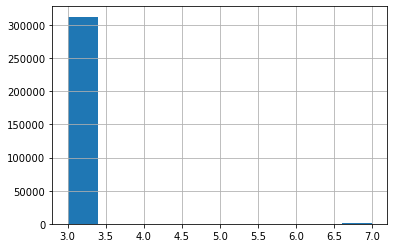

In [142]:
for_predict_df_prod['predict_ridge_12'].hist()

In [153]:
def save(wells):
    well_copy = wells.copy()
    for name_feature in well_copy.columns:
        if (name_feature != 'wellName'  and
                name_feature != 'LAYER' and
            name_feature != 'MD' and
            #name_feature != 'BK' and
             #name_feature != 'GR' and
             #name_feature != 'LIT' and
             #name_feature != 'NKTB' and
            #name_feature != 'SP' and
            name_feature != 'catBoost' and 
            name_feature != 'catBoost_prod_52' and 
            name_feature != 'catBoost_prod_152' and
            name_feature != 'catBoost_prod_100'
           ):
            print(name_feature)
            del well_copy[name_feature]
    well_copy.describe()
    well_copy.to_csv('predict_catBoost_intervals.csv', index=False)
    
save(for_predict_df_prod)

BK
GR
LIT
NKTB
SP
interval_lenght_GRinterval_0.2_
interval_lenght_SPinterval_0.2_
max_GRinterval_0.2_GR
max_SPinterval_0.2_SP
min_GRinterval_0.2_GR
min_SPinterval_0.2_SP
predict_ridge_12
